# BIG DATA ANALYTICS: Dimensionality reduction
- 차원 축소를 실습해보고, 축소된 데이터가 훈련과정과 예측에 어떠한 영향을 미치는지 알아보겠습니다
- Sources: 
    - https://github.com/rickiepark/handson-ml2
    - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
---

## 1. 데이터 로드

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)


In [3]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
X_train.shape

(52500, 784)

In [28]:
from sklearn.decomposition import PCA

#주성분의 개수를 입력하지 않을 경우 n_components == min(n_samples, n_features) - 1
pca = PCA()
pca.fit(X_train)
#numpy의 cumsum 함수는 원소를 순차적으로 합하는 역할
# np.cumsum([1,2,3,4]) = [1,3,6,10]
cumsum = np.cumsum(pca.explained_variance_ratio_)
print("Variance Length:", len(pca.explained_variance_ratio_))
print("Origin:",pca.explained_variance_ratio_[:5])
print("Cumulative sum:",cumsum[:5])
d = np.argmax(cumsum >= 0.95) + 1
#d가 의미하는 것은?

Variance Length: 784
Origin: [0.09774859 0.07169297 0.06169487 0.05401006 0.04887314]
Cumulative sum: [0.09774859 0.16944156 0.23113643 0.28514649 0.33401963]


In [5]:
d

154

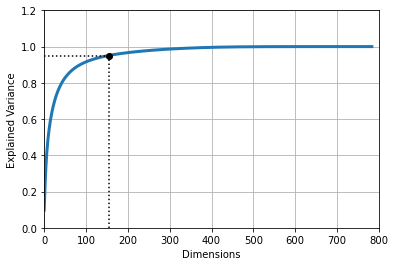

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 800, 0, 1.2])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.grid(True)

plt.show()


In [7]:
#n_components에 0.0과 1.0사이의 값을 넣으면, 자동으로 해당하는 비율의 분산을 유지하는 주성분의 개수를 계산(위에서와 같이)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)


In [8]:
pca.n_components_


154

In [9]:
np.sum(pca.explained_variance_ratio_)


0.9504082928685649

In [10]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate


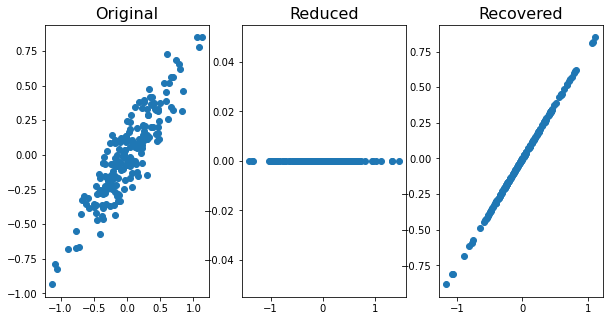

In [11]:
pca = PCA(n_components = 1)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(10,5))
plt.subplot(131)
plt.title("Original", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.subplot(132)
plt.title("Reduced", fontsize=16)
plt.scatter(X_reduced, np.zeros(len(X_reduced)))
plt.subplot(133)
plt.title("Recovered", fontsize=16)
plt.scatter(X_recovered[:,0], X_recovered[:,1])

In [12]:
#같은 의미
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
#inverse_transform은 축소되었던 데이터를 다시 원래 고차원으로 바꾸는 작업
# 물론 원본의 데이터와 차이가 있을 수 있음(전체 분산의 95%만 보존을 했기 때문에)
X_recovered = pca.inverse_transform(X_reduced)

In [13]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

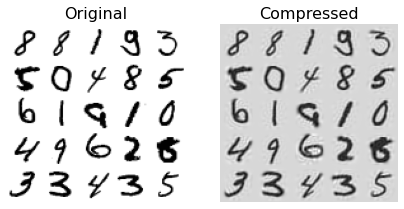

In [14]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
#Note: numpy[start:end:step]
#그러므로 아래의 X_train은 Every 2100번째의 이미지
plot_digits(X_train[::2100].to_numpy())
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)



## 차원 축소 전후의 훈련 및 예측 비교 (in Classification)

In [15]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)


In [16]:
import time

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [17]:
print("훈련 시간: {:.2f}s".format(t1 - t0))


훈련 시간: 7.04s


In [18]:
from sklearn.metrics import accuracy_score
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9226285714285715

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)


In [20]:
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train_reduced, y_train)
t1 = time.time()

In [21]:
print("훈련 시간: {:.2f}s".format(t1 - t0))


훈련 시간: 2.75s


In [22]:
#중요한 부분!
#Test데이터셋에서는 항상 transform만 사용! (fit을 포함하면, 훈련데이터와 무관하게 형성될 수 있음)
X_test_reduced = pca.transform(X_test)

y_pred = log_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9165714285714286